In [1]:
# Create viz for morphing and avg. reps on mean shape

In [2]:
!date

Sun Jun 26 12:24:22 PDT 2022


In [5]:
import os
import sys
import json
import importlib
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from scipy import stats as spstats
from aicscytoparam import cytoparam
from scipy import cluster as spcluster
from matplotlib import lines as pltlines
from aicsimageio import AICSImage, writers
from cvapipe_analysis.tools import io, viz, general, controller, shapespace, plotting

sys.path.insert(1, '../tools')
import common

In [6]:
importlib.reload(common)

<module 'common' from '/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/FigureMorphing/../tools/common.py'>

In [7]:
path_config = Path("/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/")
control = controller.Controller(general.load_config_file(path_config))
print(control.get_staging())

/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_variance


In [8]:
space = shapespace.ShapeSpaceBasic(control)
variables = control.get_variables_values_for_aggregation()
df = space.get_aggregated_df(variables).drop(columns=["structure"]).drop_duplicates().reset_index(drop=True)
df = df.loc[df.mpId==control.get_center_map_point_index()].head(1)
df

,shape_mode,mpId,aggtype,alias
4,NUC_MEM_PC1,5,avg,STR


In [9]:
row = df.loc[df.index[0]]
device = io.LocalStagingIO(control)
device.row = row

In [10]:
domain, domain_nuc, domain_mem, coords_param = common.get_map_point_shape(control, device, row)

In [ ]:
# nisos = control.get_number_of_interpolating_points()
# inner_alias = control.get_inner_most_alias_to_parameterize()
# inner_mesh = device.read_map_point_mesh(inner_alias)
# outer_alias = control.get_outer_most_alias_to_parameterize()
# outer_mesh = device.read_map_point_mesh(outer_alias)
# domain, origin = cytoparam.voxelize_meshes([outer_mesh, inner_mesh])
# coords_param, coeffs_centroid = cytoparam.parameterize_image_coordinates(
#     seg_mem=(domain>0).astype(np.uint8),
#     seg_nuc=(domain>1).astype(np.uint8),
#     lmax=control.get_lmax(), nisos=[nisos, nisos]
# )
# coeffs_mem, centroid_mem, coeffs_nuc, centroid_nuc = coeffs_centroid
# coords_param += np.array(centroid_nuc).reshape(3, 1, 1)-np.array(centroid_mem).reshape(3, 1, 1)

In [ ]:
# domain_nuc = (255*(domain>1)).astype(np.uint8)
# domain_mem = (255*(domain>0)).astype(np.uint8)

In [11]:
variables = control.get_variables_values_for_aggregation()
variables.update({"shape_mode": ["NdSphere"], "mpId": [control.get_center_map_point_index()]})
space = shapespace.ShapeSpaceBasic(control)
df = space.get_aggregated_df(variables)
df.head()

,shape_mode,mpId,aggtype,alias,structure
0,NdSphere,5,avg,STR,FBL
1,NdSphere,5,avg,STR,NPM1
2,NdSphere,5,avg,STR,SON
3,NdSphere,5,avg,STR,SMC1A
4,NdSphere,5,avg,STR,HIST1H2BJ


In [12]:
genes = ["ST6GAL1"]
dict_domain = dict([(f"domain{i}",domain==0) for i, _ in enumerate(genes)])
axy = domain.shape[-2]/domain.shape[-1]
axz = domain.shape[-3]/domain.shape[-1]

In [13]:
data = {}
for gene in genes:
    row = df.loc[df.structure==gene].iloc[0]
    if row.structure in genes:
        rep = device.read_agg_parameterized_intensity(row)
        morphed = cytoparam.morph_representation_on_shape(
            img=domain,
            param_img_coords=coords_param,
            representation=rep
        )
        data[gene] = np.stack([domain_nuc, domain_mem, morphed], axis=0)

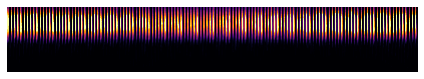

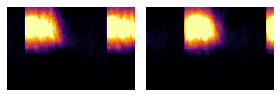

In [15]:
for gene in genes:
    row = df.loc[df.structure==gene].iloc[0]
    if row.structure in genes:
        rep = device.read_agg_parameterized_intensity(row)[0]
        
        fig, ax = plt.subplots(1,1)
        ax.imshow(rep[:,::20], cmap="inferno", vmin=0, vmax=20, origin="lower")
        ax.axis("off")
        plt.tight_layout()
        fname = f"FigureMorphing1_{gene}_rep_avg.png"
        plt.savefig(fname, dpi=150)
        plt.show()
        
        fig, axs = plt.subplots(1,2, figsize=(4,4))
        axs[0].imshow(rep[:,500:600], cmap="inferno", vmin=0, vmax=20, origin="lower")
        axs[1].imshow(rep[:,6500:6600], cmap="inferno", vmin=0, vmax=20, origin="lower")
        [ax.axis("off") for ax in axs]
        plt.tight_layout()
        fname = f"FigureMorphing1_{gene}_rep_avg_parts.png"
        plt.savefig(fname, dpi=150)
        plt.show()

In [16]:
with open("../MovieALPBaseline/contrast_V3_90OnValids.json", "r") as fj:
    contrast = json.load(fj)["contrast"]

In [20]:
contrast["ST6GAL1"]

{'z': [0, 4.031620502471924], 'y': [0, 17.91127586364746]}

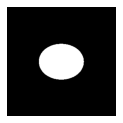

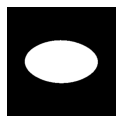

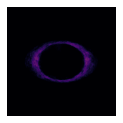

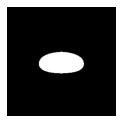

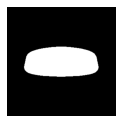

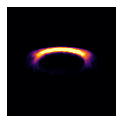

ST6GAL1 0 17.91127586364746


In [21]:
mode = {
    "nuc": "center_nuc",
    "mem": "center_nuc",
    "gfp": "center_nuc"
}
orients = ["z", "y"]
for gene, instance in data.items():
    for ax in orients:
        proj = common.Projector(instance)
        proj.set_projection_mode(ax=ax, mode=mode)
        proj.set_vmin_vmax_gfp_values(vmin=0, vmax=np.max([contrast[gene][ax][1] for ax in orients]))
        proj.project(save=f"FigureMorphing1_{gene}_avg_{ax}")
    print(gene, proj.gfp_vmin, proj.gfp_vmax)

In [ ]:
df = device.load_step_manifest("preprocessing")
print(df.shape)

In [ ]:
space = shapespace.ShapeSpace(control)
space.execute(df)
df_sphere, df_dist = space.get_cells_inside_ndsphere_of_radius(return_dist=True)
df_sphere.head()

In [ ]:
df_dist.head()

In [ ]:
not_ideal_ids = []

In [ ]:
data = {}
for gene in genes:
    
    CellIds = df_sphere.loc[df_sphere.structure==gene, "CellIds"].values[0]
    # Sort CellIds by distance from origin
    CellIds = df_dist.loc[CellIds].sort_values("Distance").index.values
    CellIds = [c for c in CellIds if c not in not_ideal_ids][:3]
    print(gene, CellIds)
    
    producers = []
    for CellId in tqdm(CellIds, leave=False, desc=gene):
        row = df.loc[CellId]
        producer = io.DataProducer(control)
        producer.set_row(row)
        producer.load_single_cell_data()
        producer.align_data()
        producers.append(producer)
    data[gene] = [p.data_aligned[[3, 5, 7]] for p in producers]

In [ ]:
mode = {
    "nuc": "max",
    "mem": "max",
    "gfp": "mean"
}
for gene, instances in data.items():
    for iid, instance in enumerate(instances):
        for ax in ["z", "y"]:
            proj = common.Projector(instance)
            proj.set_projection_mode(ax=ax, mode=mode)
            proj.set_gfp_percentiles([0, 99], local=True)
            proj.set_gfp_colormap("binary")
            proj.project(save=f"FigureMorphing1_{gene}_{iid:02d}_{ax}")

In [ ]:
!pwd